<a href="https://colab.research.google.com/github/handochan/DeepLearning/blob/master/GPM_Satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **딥러닝11팀 - 위성관측 데이터 활용 강수량 산출**

**전재홍 황수정 한도찬**

**Motivation**
- 현재 NASA에서 제공하는 위성 마이크로파 강수 산출은 물리기반의 베이지안 통계모델을 통해 제공하고 있습니다. 하지만 데이터베이스를 활용하는데 있어서 통계모델은 한계를 가지고 있기 때문에 딥러닝 기법으로 이 한계를 극복하여 더 정확한 마이크로파 위성 강수 산출을 하고자 합니다.

- 위성 레이더에서 강수량 값을 제공하고 있지만, 관측폭이 좁고, GPM Core observatory 위성에만 탑재되어 있기 때문에 실시간 전 지구 강수 관측에는 한계가 있습니다. 따라서 관측폭이 더 넓고, 여러 위성을 함께 활용할 수 있는 마이크로파 이미져 관측값으로 강수산출을 하고자 합니다.

In [1]:
# 사용할 패키지
import numpy as np
import pandas as pd
import os
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, concatenate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm import tqdm

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [4]:
import io

submission = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**활용 DATA**
- 본 대회에 사용된 자료는 NASA에서 제공된  GPM 위성 데이터를 재가공 함

GPM(Global Precipitation Measurement) Core 위성의 GMI/DPR 센서에서 
북서태평양 영역 (육지와 바다를 모두 포함) 에서 관측된 자료

특정 orbit에서 기록된 자료를 40 X 40 형태로 분할(subset) 하여 제공
subset_######_##.npy 파일로 제공되며, (height, width, channel) 형태
 subset한 각각의 이미지는 40x40x15

'######' : 위성이 사용되기 시작한 이후로 몇 번째 지구를 돌았는지 나타내는 수(orbit 번호)

'##': 해당 orbit에서 몇 번째 subset인지를 나타내는 수 
orbit별로 subset의 개수는 다를 수 있음 (subset 번호)

- Channel


채널 0-8: 밝기 온도 (단위: K, 10.65GHz~89.0GHz – 각기 다른 주파수의 마이크로파) / 위성의 마이크로파를 통해 기록한 밝기 온도를 말합니다

채널 9: 지표 타입 / (앞자리 0: 바다 / 앞자리 1: 땅 / 앞자리 2: 해안 / 앞자리 3: 강)

채널 10: GMI 경도 (마이크로파를 측정한 위치)

채널 11: GMI 위도 (마이크로파를 측정한 위치)

채널 12: DPR 경도 (마이크로파를 측정한 위치)

채널 13: DPR 위도 (마이크로파를 측정한 위치)

채널 14: 강수량 (mm/h, 결측치는 -9999.xxx 형태의 float 값으로 표기)


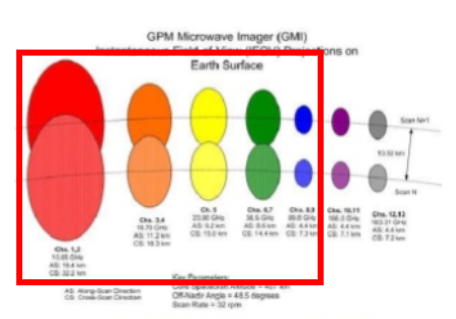

마이크로파 주파수에 따라 검출할 수 있는 비의 형태가 다릅니다. (여러가지 주파수를 함께 예측에 사용해야 함)

주파수가 낮은 영역에서는 강한 비를, 

주파수가 높은 영역에서는 약한 비 혹은 눈을 감지할 수 있습니다.

Input Data : 마이크로파를 통해 감지된 구름의 온도 9개와, 지표 type

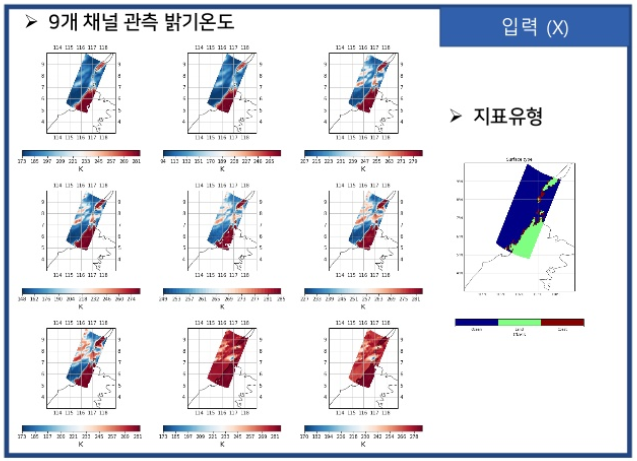

In [9]:
|import zipfile, os, shutil

dataset = '/content/gdrive/My Drive/train1.zip'
dst_path = '/content/train'
dst_file = os.path.join(dst_path, 'train1.zip')

if not os.path.exists(dst_path):
  os.makedirs(dst_path)

In [10]:
# copy zip file
shutil.copy(dataset, dst_file)
  
with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

In [11]:
train_files = os.listdir('/content/train')

Colab과 각자 노트북의 주피터 노트북으로 전부 시도를 해보았지만 데이터 전체(76,345x40x40x15)를 불러오면 시스템 메모리 과부하로 진행이 되지않아서 2017년도의 데이터(25,197x40x40x15)만 활용하였다.

In [12]:
train = []
for file in tqdm(train_files[25653:50850]): #2017년도의 데이터
    data = np.load('/content/train/'+file).astype('float32')
    train.append(data)

100%|██████████| 25197/25197 [02:35<00:00, 162.23it/s]


In [13]:
len(train)

25197

In [14]:
train = np.array(train)

In [15]:
train.shape

(25197, 40, 40, 15)

**학습할 데이터 선택**

x_train 으로는 0~10번 채널을 사용(구름온도, 지표타입)

In [16]:
x_train = train[:,:,:,:10]
y_train = train[:,:,:,14]
x_train.shape

(25197, 40, 40, 10)

In [17]:
del train #메모리 때문에 기존 train array를 삭제

Train Data에서 10%를 Test data로 활용

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=7777)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22677, 40, 40, 10), (22677, 40, 40), (2520, 40, 40, 10), (2520, 40, 40))

0보다 작은 값이 포함 된 데이터 삭제(결측치 제거)

(결측치가 -9999 형태의 float값으로 표기 되어있기때문)

In [20]:
y_train_ = y_train.reshape(-1,y_train.shape[1]*y_train.shape[2])

x_train = np.delete(x_train, np.where(y_train_<0)[0], axis=0)
y_train = np.delete(y_train, np.where(y_train_<0)[0], axis=0)
y_train = y_train.reshape(-1, x_train.shape[1], x_train.shape[2],1)
y_test = y_test.reshape(-1, y_test.shape[1], y_test.shape[2],1)

y_train_ = np.delete(y_train_, np.where(y_train_<0)[0], axis=0)

x_train.shape, y_train.shape

((22563, 40, 40, 10), (22563, 40, 40, 1))

비가 내린 셀이 50개 이상인 데이터만 선택

학습에 사용되는 Data의 크기를 줄이고 동시에 Under-Sampling 효과를 주기위함

In [21]:
is_0 = y_train_!=0
index = []
for i in tqdm(range(is_0.shape[0])):
    if is_0[i,:].sum()>=50:
        index.append(i)

100%|██████████| 22563/22563 [00:00<00:00, 131205.20it/s]


In [22]:
x_train = x_train[index,:,:,:]
y_train = y_train[index,:,:,:]

x_train.shape, y_train.shape

((9136, 40, 40, 10), (9136, 40, 40, 1))

**평가 함수 정의**

미리 데이콘에서 정의된 함수

In [23]:
def mae_over_fscore(y_true, y_pred):
    '''
    y_true: sample_submission.csv 형태의 실제 값
    y_pred: sample_submission.csv 형태의 예측 값
    '''

    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    
    # 실제값이 0.1 이상인 픽셀의 위치 확인
    IsGreaterThanEqualTo_PointOne = y_true >= 0.1
    
    # 실제 값에 결측값이 없는 픽셀의 위치 확인 
    IsNotMissing = y_true >= 0
    
    # mae 계산
    mae = np.mean(np.abs(y_true[IsGreaterThanEqualTo_PointOne] - y_pred[IsGreaterThanEqualTo_PointOne]))
    
    # f1_score 계산 위해, 실제값에 결측값이 없는 픽셀에 대해 1과 0으로 값 변환
    y_true = np.where(y_true[IsNotMissing] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[IsNotMissing] >= 0.1, 1, 0)
    
    # f1_score 계산    
    f_score = f1_score(y_true, y_pred) 
    # f1_score가 0일 나올 경우를 대비하여 소량의 값 (1e-07) 추가 
    return mae / (f_score + 1e-07)

손실 함수 정의

Baseline에 정의된 함수

In [37]:
def mae(y_true, y_pred):    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def score(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

Build Model & Training (ResNet)

강수량을 예측할 지점에서 멀리 있는 데이터일 수록 영향이 적어져 Pooling Layer 가 결과 예측에 방해가 될 것으로 예상

따라서 Pooling Layer를 추가하지 않고 Convolution 과 Residual Block 만으로 Model Building

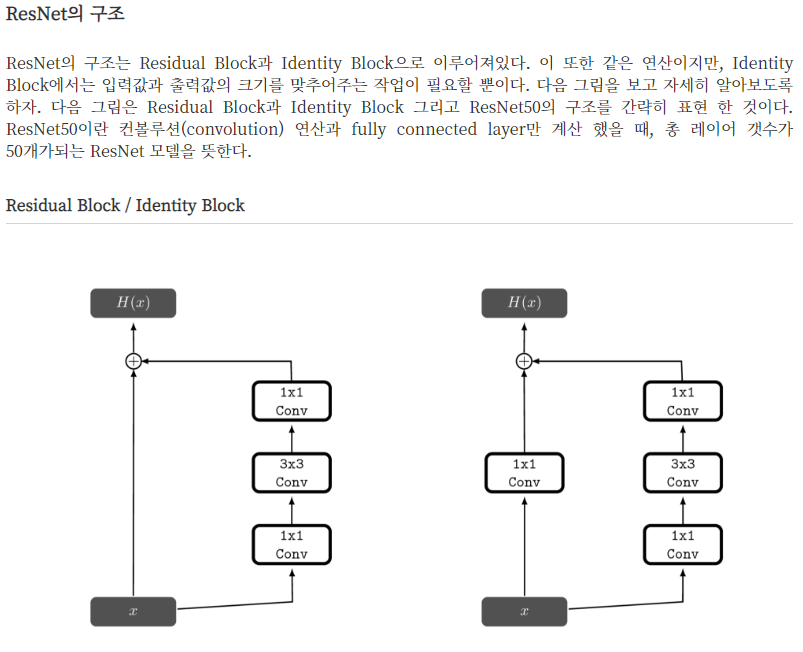

In [25]:
def create_model():
    inputs=Input(x_train.shape[1:])
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

K - Fold Validation

In [29]:
def train_model(x_data, y_data, k, s):
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=7777)
    
    for model_number in range(s):
        for  train_idx, val_idx in k_fold.split(x_data):
            x_train, y_train = x_data[train_idx], y_data[train_idx]
            x_val, y_val = x_data[val_idx], y_data[val_idx]

            model = create_model()

            model.compile(loss='mae', optimizer='adam', metrics=[score, fscore_keras])

            callbacks_list = [
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=3,
                    factor=0.8
                ),

                tf.keras.callbacks.ModelCheckpoint(
                    filepath = '/content/gdrive/My Drive/newmodel/model'+str(model_number)+'.h5'
                    monitor='val_score',
                    save_best_only=True
                )
            ]

            model.fit(x_train, y_train, epochs=7, batch_size=128, validation_data=(x_val, y_val), callbacks=callbacks_list)

 Data Augmentation을 시도해 보았으나 학습하는 과정에서 시스템 메모리가 과부하

In [30]:
k = 3
models = []

train_model(x_train, y_train, k=k, s=3)

for n in range(k):
    model = load_model('/content/gdrive/My Drive/newmodel/model'+str(n)+'.h5', custom_objects = {'score':score,'fscore_keras':fscore_keras})
    models.append(model)

Epoch 1/7
48/48 [==============================] - 78s 2s/step - loss: 0.4589 - score: 3.8293 - fscore_keras: 0.5461 - val_loss: 3.1044 - val_score: 11.8938 - val_fscore_keras: 0.2691 - lr: 0.0010
Epoch 2/7
48/48 [==============================] - 67s 1s/step - loss: 0.2604 - score: 2.4192 - fscore_keras: 0.6742 - val_loss: 0.3393 - val_score: 5.8526 - val_fscore_keras: 0.3649 - lr: 0.0010
Epoch 3/7
48/48 [==============================] - 66s 1s/step - loss: 0.2488 - score: 2.2587 - fscore_keras: 0.6913 - val_loss: 0.3467 - val_score: 19.3075 - val_fscore_keras: 0.1175 - lr: 0.0010
Epoch 4/7
48/48 [==============================] - 66s 1s/step - loss: 0.2429 - score: 2.1500 - fscore_keras: 0.7081 - val_loss: 0.3466 - val_score: 20.7400 - val_fscore_keras: 0.1098 - lr: 0.0010
Epoch 5/7
48/48 [==============================] - 66s 1s/step - loss: 0.2380 - score: 2.0599 - fscore_keras: 0.7204 - val_loss: 0.3436 - val_score: 16.0272 - val_fscore_keras: 0.1395 - lr: 0.0010
Epoch 6/7
48/48 

KeyError: ignored

##평가 지표
평가 지표는 MAE를 F1 score로 나눈 값입니다. 이 때 MAE는 실제 값이 0.1 이상인 픽셀에 대해서만 산출하며, F1 score는 해당 픽셀의 강수량이 0.1 이상이면 1, 0.1 미만이면 0으로 변환 후 1에 대해 F1 score를 산출합니다. 실제 값에 결측치(-9999.xxx)가 포함된 경우, 결측치가 포함된 픽셀은 F1 score 계산에서 제외 합니다. 

회귀의 평가를 위한 지표는 실제 값과 회귀 예측값의 차이를 기반으로 합니다. 회귀 평가지표 MAE, MSE, RMSE, MSLE, RMSLE는 값이 작을수록 회귀 성능이 좋은 것입니다. 값이 작을수록 예측값과 실제값의 차이가 없다는 뜻이기 때문입니다. 반면, R² 는 값이 클수록 성능이 좋습니다.

MAE (Mean Absolue Error) : 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균한 것

F1 score : precision 과 recall의 조화평균이다. F1 score는 precision과 recall을 조합하여 하나의 통계치를 반환한다. 여기서 일반적인 평균이 아닌 조화 평균을 계산하였는데, 그 이유는 precision과 recall이 0 에 가까울수록 F1 score도 동일하게 낮은 값을 갖도록 하기 위함이다.

In [39]:
best_model1 = load_model('/content/gdrive/My Drive/newmodel/model0.h5', custom_objects = {'score':score,'fscore_keras':fscore_keras})

In [40]:
models.append(best_model1)

In [41]:
best_model2 = load_model('/content/gdrive/My Drive/newmodel/model1.h5', custom_objects = {'score':score,'fscore_keras':fscore_keras})

In [42]:
models.append(best_model2)

In [43]:
best_model3 = load_model('/content/gdrive/My Drive/newmodel/model2.h5', custom_objects = {'score':score,'fscore_keras':fscore_keras})

In [44]:
models.append(best_model3)

In [45]:
preds = []
for model in models:
    preds.append(model.predict(x_test))
    print(mae_over_fscore(y_test, preds[-1]))

pred = sum(preds)/len(preds)
print(mae_over_fscore(y_test, pred))

9.074320412097494
5.268336200143428
7.651416719353927
9.87480768492184


model2가 가장 좋은 성능을 내는 것으로 확인!

In [62]:
mae(y_test, best_model2.predict(x_test))

1.9884937

MAE (Mean Absolute Error) : 평균 절대 오차

실제 강수량 데이터와 약 1.988mm 차이

In [49]:
pred2 = []
pred2.append(best_model2.predict(x_test))
print(mae_over_fscore(y_test, pred2[-1]))

5.268336200143428


데이콘에서 설정한 평가 지표인데 약 5.2683으로 리더보드 기준으로 740팀중 130위에 해당하는 점수입니다.